# 新闻分类 (PyTorch + TensorBoard)
## 作者: 2252938沈诗凡

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import numpy as np

In [40]:
# 数据加载
num_words = 10000  # 只取前1万高频词
maxlen = 200       # 每条新闻统一长度
(x_train, y_train), (x_test, y_test) = reuters.load_data( num_words=num_words)

# 拆分验证集
val_size = int(len(x_train) * 0.2)
x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]

# 序列填充
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# 转为Tensor
X_train = torch.tensor(x_train, dtype=torch.long)
X_val = torch.tensor(x_val, dtype=torch.long)
X_test = torch.tensor(x_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)


batch_size = 64
# batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [41]:
# 模型定义
class ReutersNet(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=128, hidden_dims=[128], num_classes=46):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        layers = []
        in_dim = embed_dim * maxlen
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.embedding(x)             # [batch, seq_len, embed_dim]
        x = x.view(x.size(0), -1)         # flatten
        return self.net(x)

# 尝试不同结构
# hidden_dims = [128, 64, 32]
# hidden_dims = [64, 64]
hidden_dims = [256, 128]
model = ReutersNet(vocab_size=num_words, embed_dim=256, hidden_dims=hidden_dims)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ReutersNet(
  (embedding): Embedding(10000, 256)
  (net): Sequential(
    (0): Linear(in_features=51200, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=46, bias=True)
  )
)

In [42]:
# 训练配置
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
writer = SummaryWriter(log_dir=f"runs/reuters_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

best_val_acc = 0
patience = 5
patience_counter = 0
num_epochs = 40
best_model_path = r"./models/best_reuters_model.pth"


In [43]:
# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (out.argmax(1) == yb).sum().item()

    train_acc = train_correct / len(train_ds)

    # 验证
    model.eval()
    val_correct, val_loss = 0, 0
    with torch.no_grad():
        for xv, yv in val_loader:
            xv, yv = xv.to(device), yv.to(device)
            out = model(xv)
            loss = criterion(out, yv)
            val_loss += loss.item()
            val_correct += (out.argmax(1) == yv).sum().item()
    val_acc = val_correct / len(val_ds)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    writer.add_scalar('Loss/train', train_loss/len(train_loader), epoch)
    writer.add_scalar('Loss/val', val_loss/len(val_loader), epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    # early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Validation stopped improving. Early stopping.")
            break

writer.close()

Epoch [1/40] Train Acc: 0.3706, Val Acc: 0.4170
Epoch [2/40] Train Acc: 0.5182, Val Acc: 0.4705
Epoch [3/40] Train Acc: 0.5941, Val Acc: 0.4761
Epoch [4/40] Train Acc: 0.6507, Val Acc: 0.5150
Epoch [5/40] Train Acc: 0.6874, Val Acc: 0.5061
Epoch [6/40] Train Acc: 0.7234, Val Acc: 0.5290
Epoch [7/40] Train Acc: 0.7523, Val Acc: 0.5262
Epoch [8/40] Train Acc: 0.7814, Val Acc: 0.5345
Epoch [9/40] Train Acc: 0.7970, Val Acc: 0.5434
Epoch [10/40] Train Acc: 0.8091, Val Acc: 0.5507
Epoch [11/40] Train Acc: 0.8287, Val Acc: 0.5618
Epoch [12/40] Train Acc: 0.8318, Val Acc: 0.5401
Epoch [13/40] Train Acc: 0.8401, Val Acc: 0.5573
Epoch [14/40] Train Acc: 0.8553, Val Acc: 0.5551
Epoch [15/40] Train Acc: 0.8594, Val Acc: 0.5590
Epoch [16/40] Train Acc: 0.8629, Val Acc: 0.5546
Validation stopped improving. Early stopping.


In [44]:
# 测试集评估
model.load_state_dict(torch.load(best_model_path))
model.eval()
test_correct = 0
with torch.no_grad():
    for xt, yt in test_loader:
        xt, yt = xt.to(device), yt.to(device)
        out = model(xt)
        test_correct += (out.argmax(1) == yt).sum().item()

test_acc = test_correct / len(test_ds)
print(f"测试集准确率: {test_acc:.4f}")

测试集准确率: 0.5601


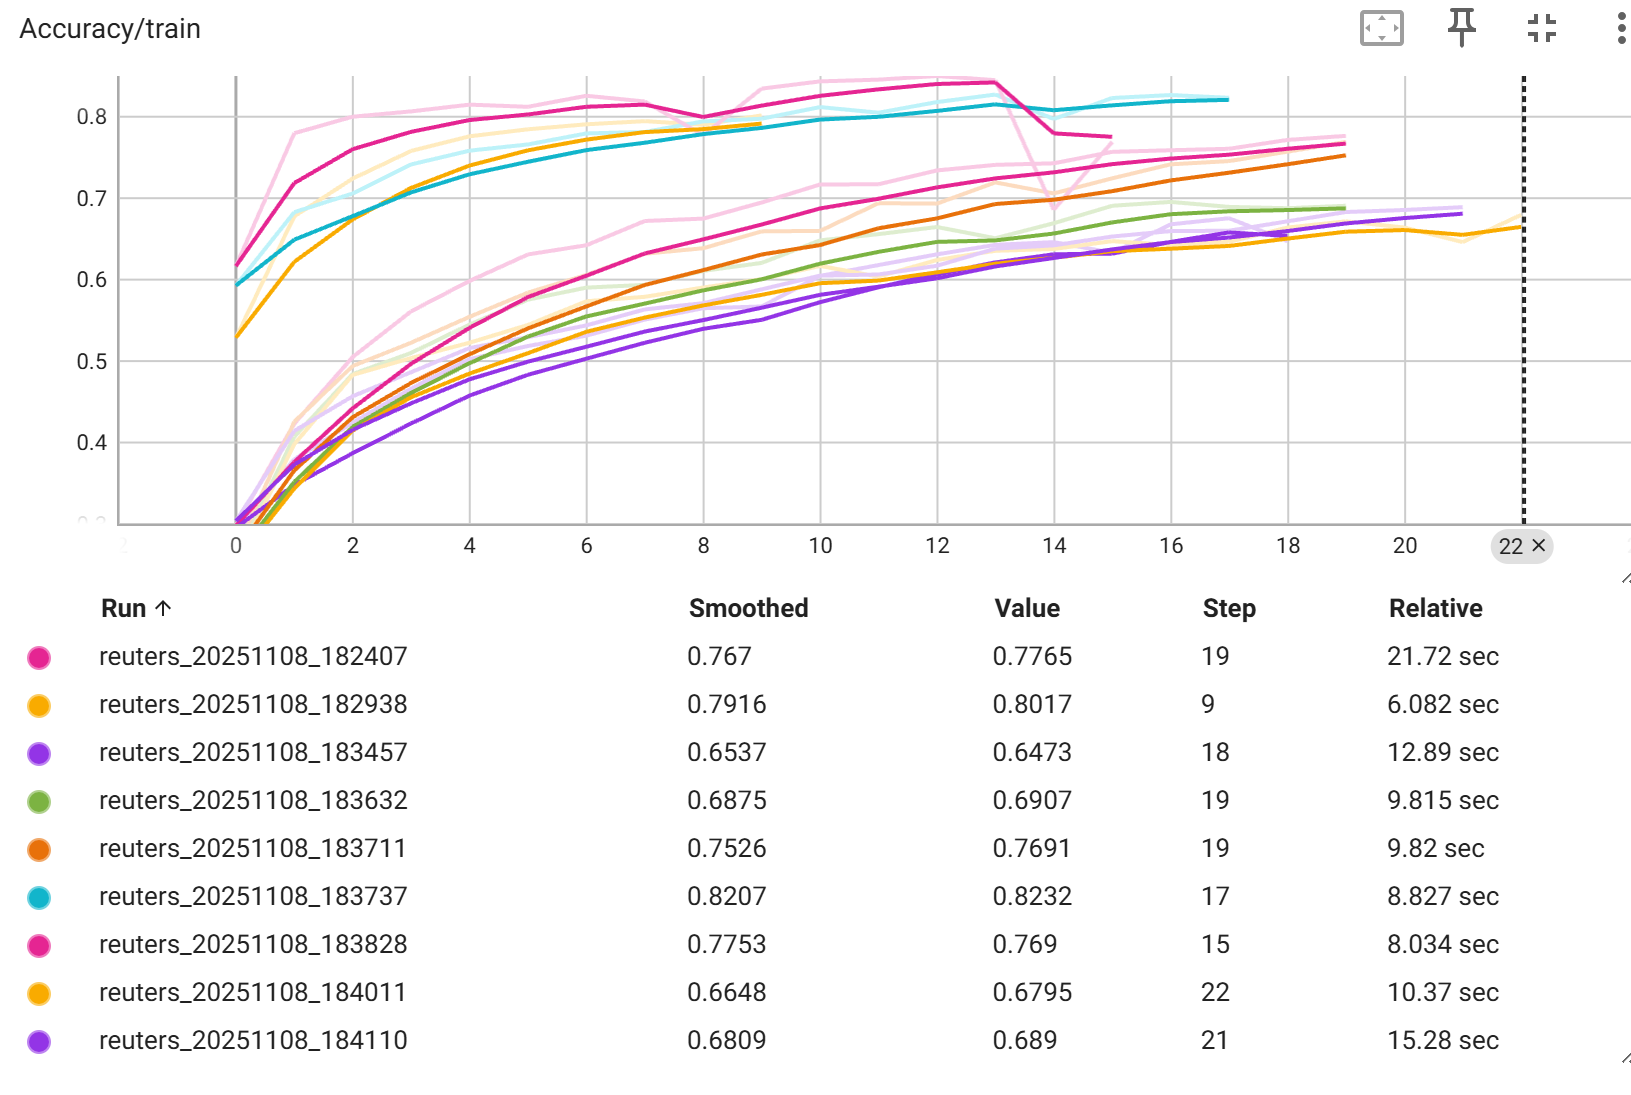

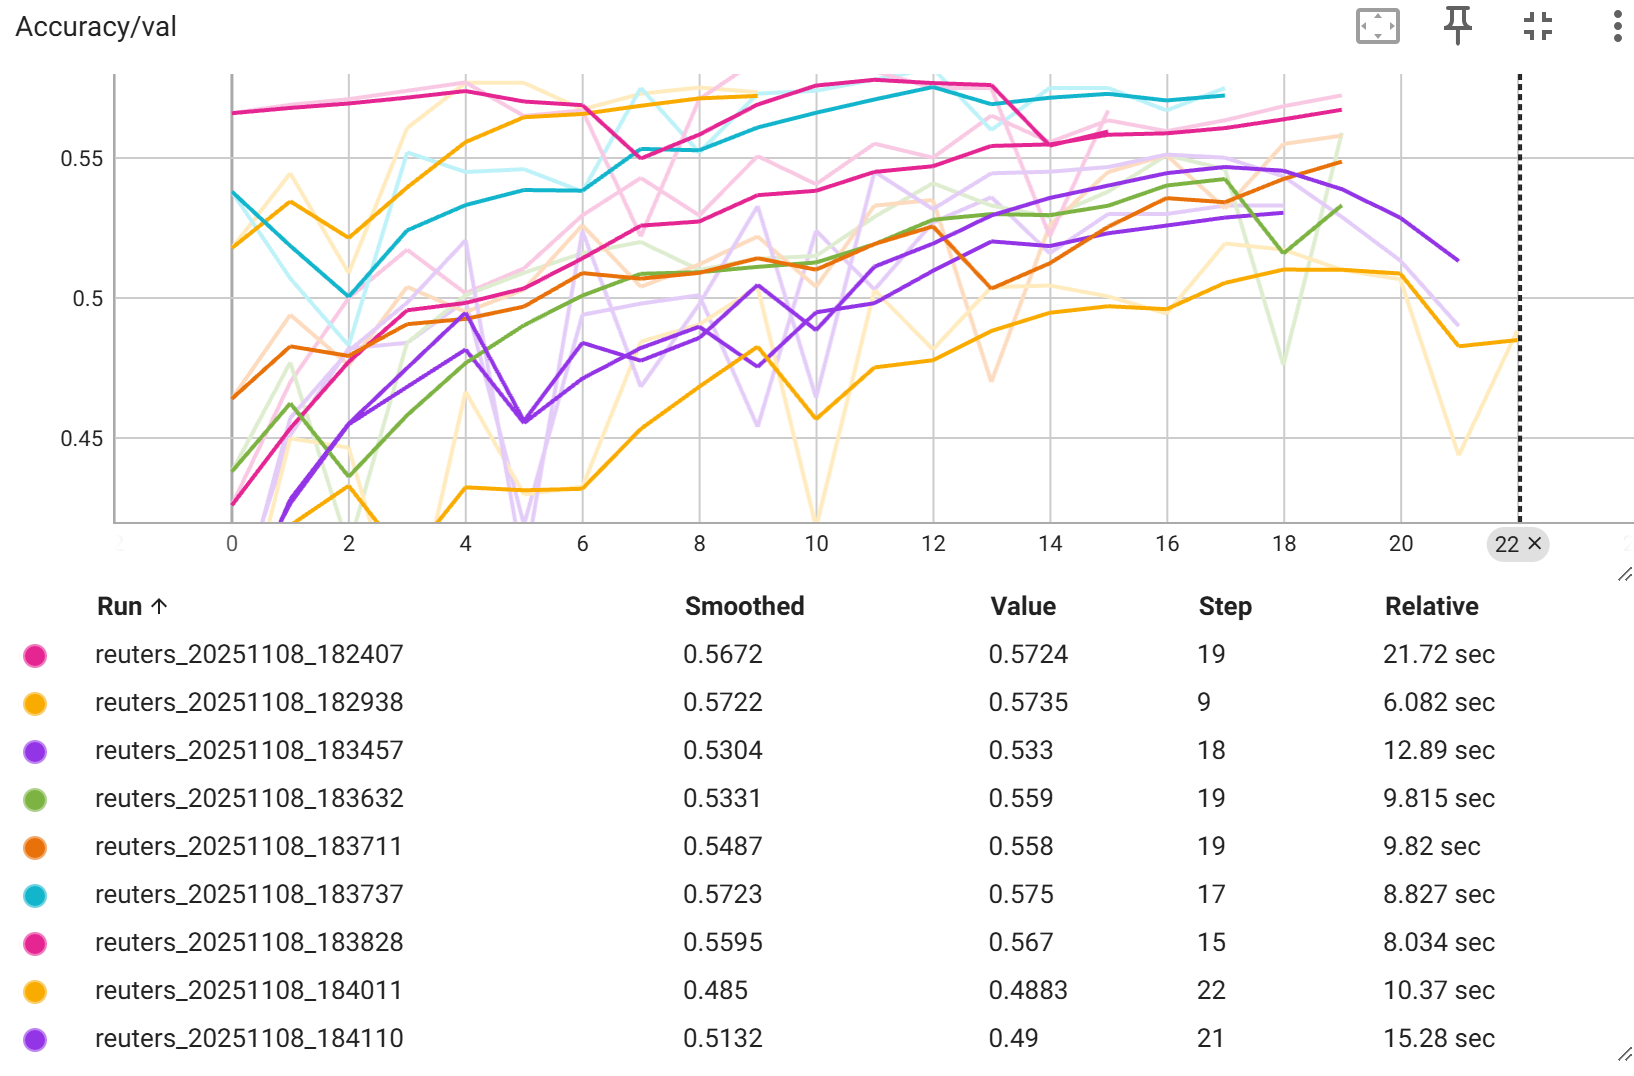

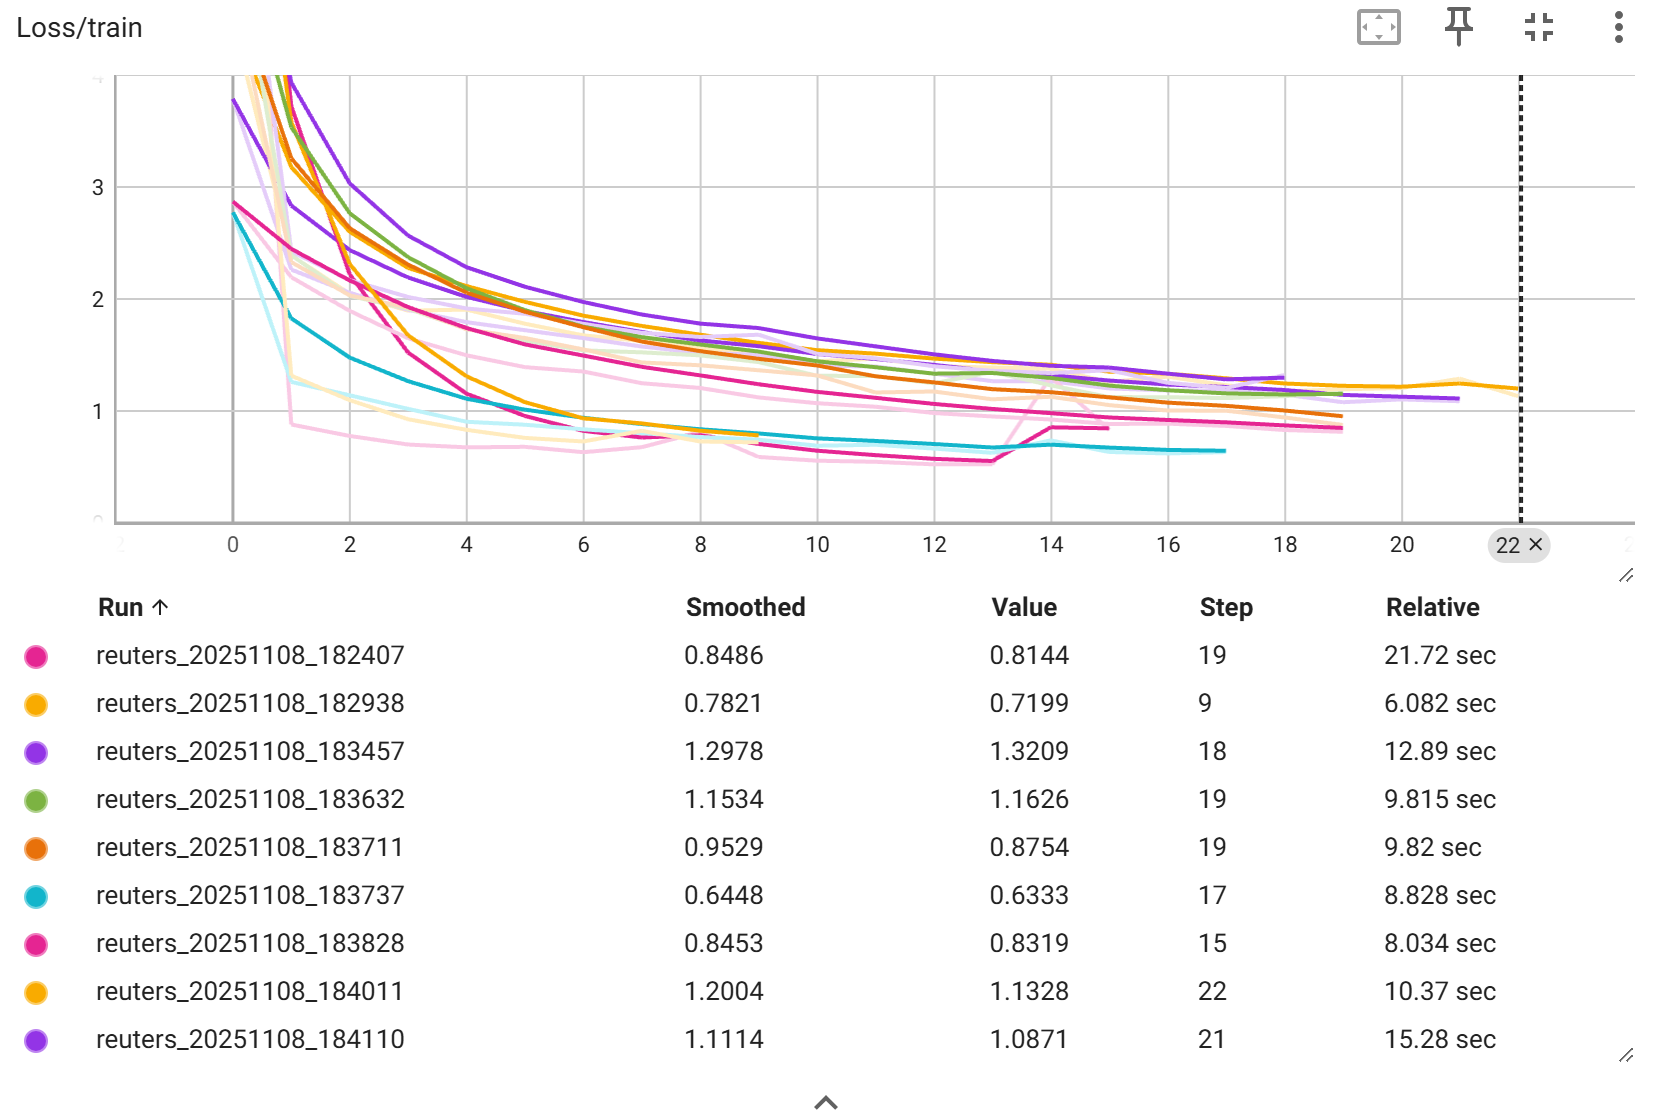

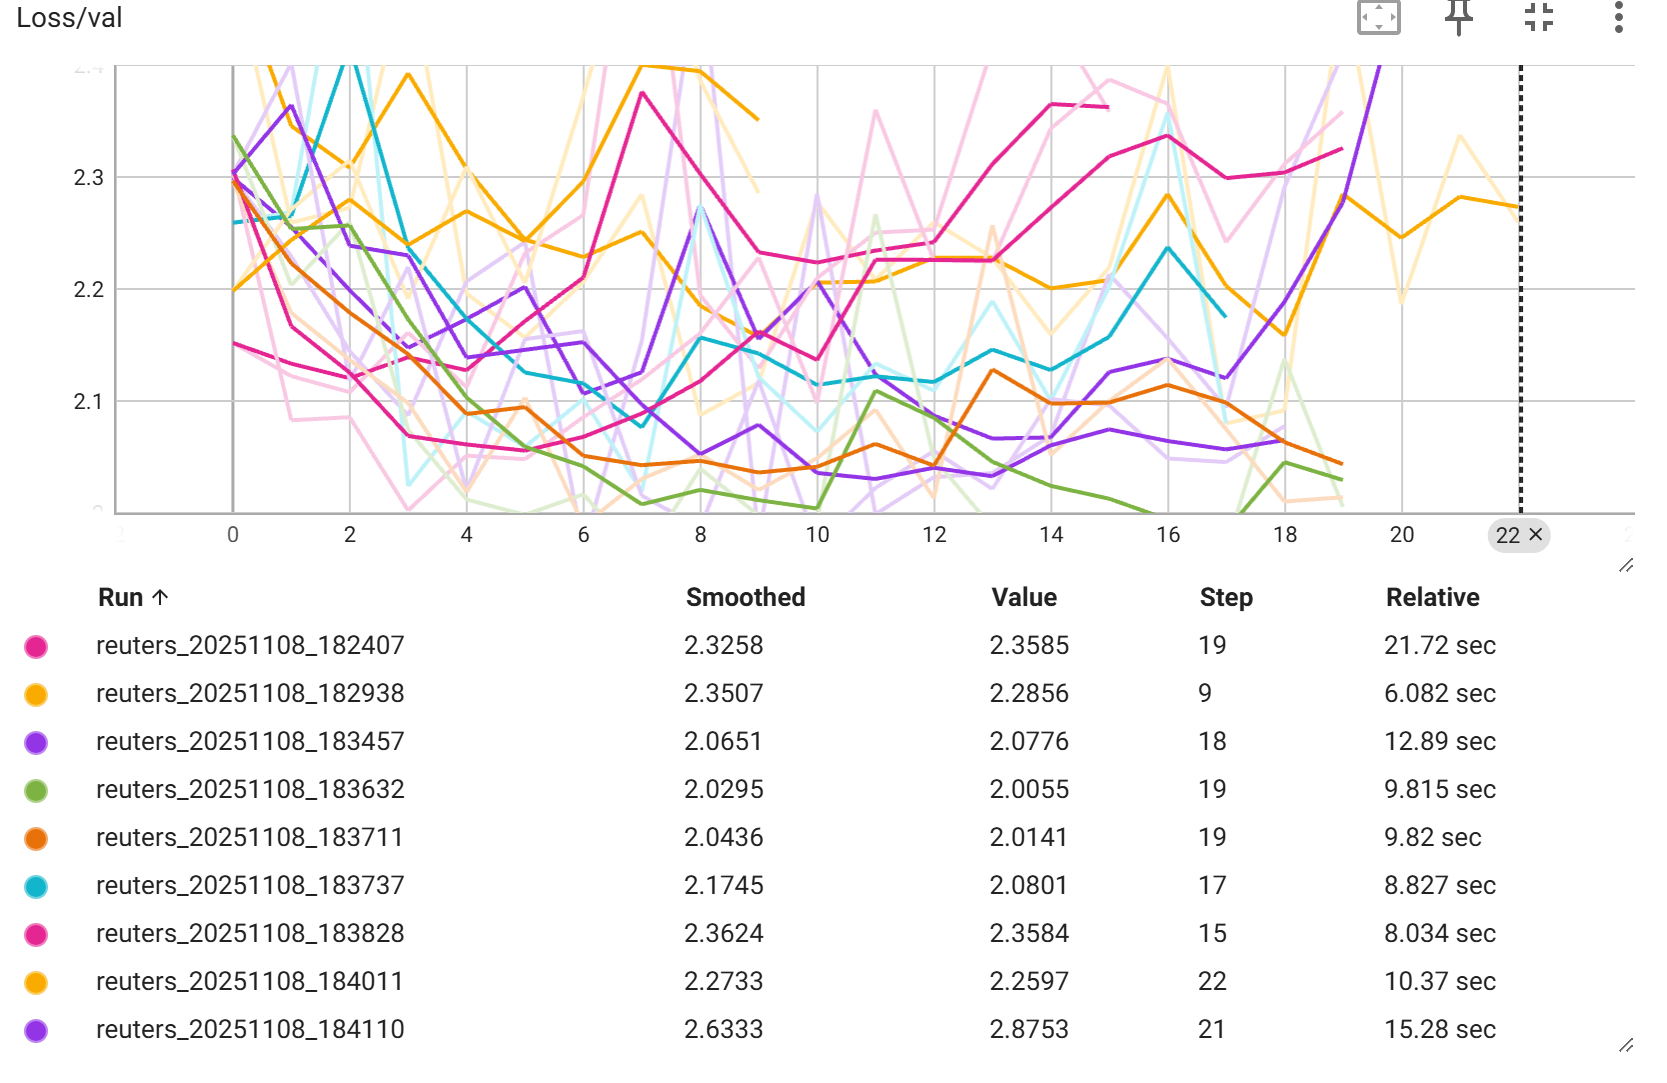